In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, box
import datetime as dt

In [2]:
nodes = pd.read_csv("node_data.csv")
edges = pd.read_csv("edges_data.csv")
df_2020 = pd.read_csv("data\scats_detector_volume_jan-jun-2020.csv")
sites = pd.read_csv("data\its_scats_sites_aug-2020.csv")

In [3]:
columns_to_load = ["End_Time", "Site", "Detector", "Sum_Volume", "Avg_Volume"]
March2025 = pd.read_csv("data/SCATSMarch2025.csv", usecols=columns_to_load)

In [4]:
April2025 = pd.read_csv("data/SCATSApril2025.csv", usecols=columns_to_load)

In [5]:
May2025 = pd.read_csv("data/SCATSMay2025.csv", usecols=columns_to_load)

In [6]:
df  = pd.concat([March2025, April2025], ignore_index=True)

In [7]:
geo_edges=edges.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_edges['geometry'] = edges['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_edges = gpd.GeoDataFrame(geo_edges, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_edges.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_edges))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [8]:
geo_nodes=nodes.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_nodes['geometry'] = nodes['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_nodes = gpd.GeoDataFrame(geo_nodes, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_nodes.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_nodes))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [9]:
sites = sites[~((sites["Lat"] == 0) | (sites["Long"] == 0))]
geo_sites = gpd.GeoDataFrame(
    sites,
    geometry=gpd.points_from_xy(sites['Long'], sites['Lat']),
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)

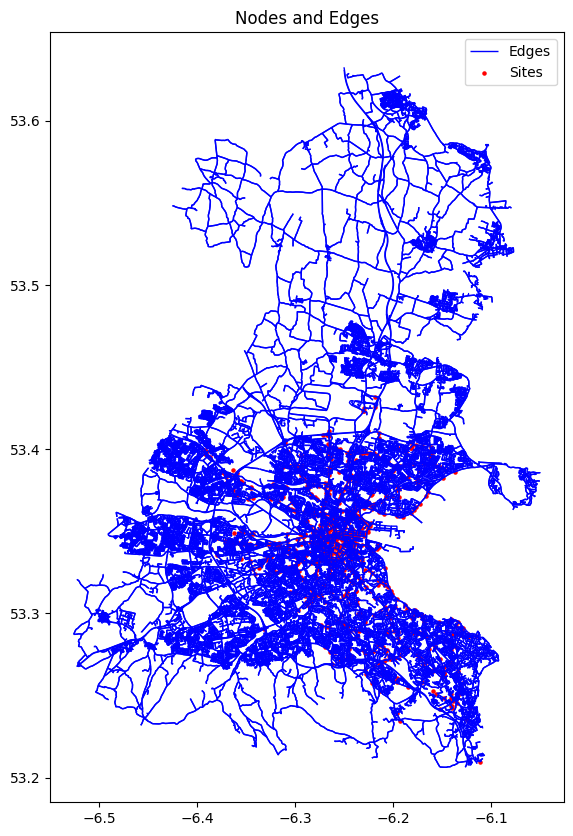

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot edges first (usually as lines)
geo_edges.plot(ax=ax, color='blue', linewidth=1, label='Edges')

# Plot nodes on top (usually as points)
geo_sites.plot(ax=ax, color='red', markersize=5, label='Sites')

# Optional: add a legend and title
plt.legend()
plt.title("Nodes and Edges")

plt.show()

In [11]:
# Get bounding box of all points
minx, miny, maxx, maxy = geo_edges.total_bounds

# Define grid size (in the CRS units, e.g., degrees if EPSG:4326)
nx = 10  # number of columns
ny = 10  # number of rows
xgrid = np.linspace(minx, maxx, nx+1)
ygrid = np.linspace(miny, maxy, ny+1)

# Create grid polygons
polygons = []
for i in range(nx):
    for j in range(ny):
        polygons.append(box(xgrid[i], ygrid[j], xgrid[i+1], ygrid[j+1]))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=geo_edges.crs)

In [12]:
df_small = df[["End_Time","Site","Sum_Volume"]]  # only necessary columns
geo_small = geo_sites[['SiteID', 'geometry']]
df_small['Site'] = df_small['Site'].astype('category')
geo_small['SiteID'] = geo_small['SiteID'].astype('category')

C:\Users\Sean Murphy\AppData\Local\Temp\ipykernel_11184\2462526846.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['Site'] = df_small['Site'].astype('category')
C:\Users\Sean Murphy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
gdf = pd.merge(df_small, geo_small, left_on ="Site", right_on = "SiteID", how = "inner")
gdf.head()


,End_Time,Site,Sum_Volume,SiteID,geometry
0,20250313010000,58,0,58.0,POINT (-6.26523 53.35605)
1,20250313010000,58,5,58.0,POINT (-6.26523 53.35605)
2,20250313010000,58,0,58.0,POINT (-6.26523 53.35605)
3,20250313010000,58,0,58.0,POINT (-6.26523 53.35605)
4,20250313010000,58,0,58.0,POINT (-6.26523 53.35605)


In [22]:
gdf=gdf.drop("SiteID", axis = 1)
gdf.head()

,End_Time,Site,Sum_Volume,geometry
0,20250313010000,58,0,POINT (-6.26523 53.35605)
1,20250313010000,58,5,POINT (-6.26523 53.35605)
2,20250313010000,58,0,POINT (-6.26523 53.35605)
3,20250313010000,58,0,POINT (-6.26523 53.35605)
4,20250313010000,58,0,POINT (-6.26523 53.35605)


In [23]:
gdf = gpd.GeoDataFrame(
    gdf,
    geometry=gdf["geometry"],
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)

In [24]:
gdf.to_parquet("data/gdf.parquet",engine = "pyarrow", index = False)

In [32]:
# Spatial join points to grid boxes
joined = gpd.sjoin(gdf, grid, how='left', predicate='within')

# Sum Sum_volume per grid cell
grid_sum = joined.groupby('index_right')['Sum_Volume'].sum()

# Assign sums to the grid GeoDataFrame
grid['Sum_volume'] = grid_sum
grid['Sum_volume'] = grid['Sum_volume'].fillna(0)  # fill empty cells


MemoryError: Unable to allocate 310. MiB for an array with shape (3, 13549486) and data type int64

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
grid.plot(column='Sum_Volume', ax=ax, cmap='OrRd', legend=True, edgecolor='k')
plt.title("Sum of Sum_volume per grid cell")
plt.show()